In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sqlite3 as sql
import sys
import yfinance as yf

In [2]:
sys.path.append('../')

from src.db_default import DB_DIR, DB_FROZEN_VARIANTS
from src.db_class import DBCursor, FinanceDB

### Pulling data from DB

In [3]:
db_variant_label = 'v1'
db_filename = DB_FROZEN_VARIANTS['v1']['db_filename']
finance_db = FinanceDB(db_filename)

In [4]:
ticker = 'BTC-USD'
df = finance_db.get_daily_per_ticker(ticker)

In [5]:
#print(df)

### Prepare Random Forest

#### Settings

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [7]:
column_choice = 'close'
use_random_data_instead_of_database = False

assert column_choice in ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']

In [8]:
seed_1 = 0  # for random data gen
seed_2 = 0  # for train test split
seed_3 = 0  # for RandomForest classifier

In [9]:
seq_size = 5

#### Prep data

In [10]:
if use_random_data_instead_of_database:
    np.random.seed(seed_1)
    raw_data = np.random.normal(loc=1, scale=0.1, size=100000)
else:
    raw_data = df[column_choice].values

# np.random.shuffle(raw_data)

In [11]:
frac_diff = raw_data[1:] - raw_data[:-1]
# frac_diff = diff / raw_data[:-1]
# frac_diff = raw_data

n_samples = len(frac_diff) // (seq_size+1)
if len(frac_diff) % (seq_size+1) != 0:
    relative_data = frac_diff[:-(len(frac_diff) % (seq_size+1))]
else:
    relative_data = frac_diff
    
relative_data = relative_data.reshape((n_samples, (seq_size+1)))

X = relative_data[:, :seq_size]
Y = np.sign(relative_data[:, -1])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=seed_2)

#### Analyze data

18.368944785660542


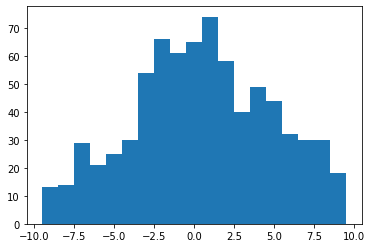

In [12]:
print(np.mean(frac_diff))

plt.hist(frac_diff, bins=np.linspace(-9.5, 9.5, 20))
plt.show()

0.1085972850678733


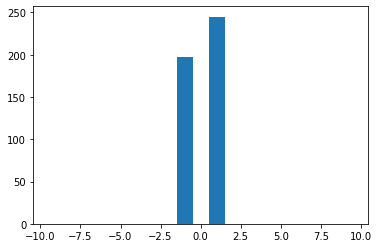

In [13]:
print(np.mean(Y))

plt.hist(Y, bins=np.linspace(-9.5, 9.5, 20))
plt.show()

#### Train classifer

In [14]:
classifer = RandomForestClassifier

myRF_clf = classifer(
        n_estimators=100,
        max_depth=None, 
        min_samples_split=2, # minimum number of sample per leaf
        oob_score=True,
        random_state=seed_3,
        warm_start=False # this ensures that you add estimators without retraining everything
    )

In [15]:
myRF_clf.fit(X_train, Y_train)

print(myRF_clf.score(X_train,Y_train), myRF_clf.oob_score_)
print(myRF_clf.score(X_test,Y_test))

1.0 0.5184135977337111
0.5056179775280899


In [16]:
print(X.shape, Y.shape)

(442, 5) (442,)


In [17]:
print(X[:10], Y[:10])

[[-32.89401245 -29.64401245  14.10800171 -10.08297729   3.33099365]
 [-12.58599854 -11.63098145  -7.14901733  -4.90499878 -22.33898926]
 [ 11.47698975  -3.32901001  -8.54299927 -15.55999756 -30.64599609]
 [  9.56900024   6.10800171  16.75299072  12.08599854  -3.46398926]
 [ 16.25        11.86499023  10.45599365  -6.09698486 -12.2170105 ]
 [  7.68399048  -1.89599609  -6.70098877   3.63000488  -3.3170166 ]
 [ -0.07199097 -11.07400513   7.43301392  -1.71499634   4.6289978 ]
 [  9.71398926  -6.98397827 -12.57202148   0.14300537   1.6619873 ]
 [  8.99398804   9.80401611  -6.875        3.07299805  17.77600098]
 [  0.77099609  55.86599731  -2.82601929 -22.91699219 -21.68499756]] [ 1. -1. -1.  1.  1. -1. -1.  1.  1.  1.]


In [18]:
print(sum(Y_train), sum(Y_test))

43.0 5.0
